In [1]:
#Destination Earth: ClimateDT paper plot
#Author: Aleks Lacima

# Load libraries
import xarray as xr
import numpy as np
import scipy as sc
from scipy import stats
import pandas as pd
import os
import sys
from tqdm import tqdm
import dask as da
from datetime import datetime as dt

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

In [2]:
#Plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cmocean import cm as cmo
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as patches
import matplotlib.colors as mpc
import matplotlib.ticker as ticker
%matplotlib inline

In [3]:
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [4]:
startdate = '2024-01-01T00'
enddate = '2025-01-01T00'
tvec = np.arange(np.datetime64(startdate+':00:00'), np.datetime64(enddate+':00:00'),dtype='datetime64[D]')
x = []
for i in range(len(tvec)):
    x.append(str(tvec[i]).replace('-',''))

In [5]:
#Global Wind Atlas color scale

from matplotlib.colors import LinearSegmentedColormap

#Define the RGB values for the color scale.
colors = [
    (153, 51, 102),
    (165, 47, 90),
    (176, 43, 77),
    (188, 39, 65),
    (199, 35, 52),
    (211, 31, 40),
    (226, 63, 40),
    (232, 78, 41),
    (238, 92, 41),
    (245, 106, 41),
    (246, 137, 53),
    (247, 160, 63),
    (248, 184, 73),
    (249, 208, 82),
    (250, 232, 92),
    (212, 221, 87),
    (178, 211, 83),
    (145, 202, 79),
    (111, 192, 75),
    (73, 181, 70),
    (73, 173, 99),
    (73, 165, 124),
    (72, 158, 148),
    (72, 150, 173),
    (72, 142, 202),
    (90, 158, 212),
    (106, 173, 220),
    (123, 187, 229),
    (141, 204, 238),
    (178, 226, 249),
    (197, 233, 250)
]

normalized_colors = np.array(colors)/255.0

# Create a custom colormap with these colors
cmap = LinearSegmentedColormap.from_list('GWA', normalized_colors)

cmap_gwa = cmap.reversed()

### Global map of wind

In [6]:
path_input = '/gpfs/scratch/bsc32/bsc032984/data/destine/historical/a1ym/ws100/'

ds_ws = xr.open_mfdataset(path_input + '*.nc', combine='nested', concat_dim='time')
ds_ws.close()

In [7]:
ws = ds_ws['100si'][:,0,:,:]
ws_mean = ws.mean(dim='time')

In [8]:
ws_mean

<xarray.DataArray '100si' (lat: 1800, lon: 3600)> Size: 52MB
dask.array<mean_agg-aggregate, shape=(1800, 3600), dtype=float64, chunksize=(1800, 3600), chunktype=numpy.ndarray>
Coordinates:
    level    int64 8B 100
  * lat      (lat) float64 14kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9

In [9]:
#Plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.io import shapereader
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from cmocean import cm as cmo
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as patches
import matplotlib.colors as mpc
%matplotlib inline

In [19]:
def plot_map(data, ds, xmin, xmax, colormap, label, title, delta=12, region='eur', grid='pcolormesh', extend='neither', zero_contour=False, path_output=None):   
    import matplotlib.ticker as ticker
    from matplotlib.patches import Rectangle
    
    data_crs = ccrs.Robinson() #Type of projection.
    if region == 'eur':
        data_crs = ccrs.PlateCarree()
    if region == 'iber':
        data_crs = ccrs.PlateCarree()
    if region == 'nsea':
        data_crs = ccrs.PlateCarree()
    fig = plt.figure(constrained_layout=True, figsize=(20,14))
    #For multiplots
    fig.subplots_adjust(bottom=0.14, top=0.90, left=0.05, right=0.95)
    nrow = 1
    ncol = 1
    outer = gs.GridSpec(nrow, ncol, wspace=0.01, hspace=0.02)

    var = data
    lon = ds.lon.values
    lat = ds.lat.values

    fsize = 17 #Fontsize
    for i in range(nrow*ncol):
        ax = plt.subplot(outer[i], projection = data_crs)
        if region == 'eur':
            ax.set_extent([-25.0, 45.0, 27.0, 72.0], crs=data_crs)
        elif region == 'iber':
            ax.set_extent([-10.0, 5.0, 35.0, 45.0], crs=data_crs)
        elif region == 'nsea':
            ax.set_extent([-4.5, 9.25, 51.0, 61.0], crs=data_crs)
        else:
            pass
        
        ax.coastlines(resolution = '10m') #Draws the coastline.
        #ax.add_feature(cfeature.LAKES, edgecolor = 'black') #Adds lakes.
        #ax.add_feature(cfeature.RIVERS, alpha=0.5) #Adds rivers.
        #ax.add_feature(cfeature.BORDERS) #Adds borders
        
        gl = ax.gridlines(draw_labels = True, linestyle='dashed', alpha=0.25) #Draws meridians and parallels.
        gl.xlabels_top = False
        gl.ylabels_right = False

        vmin,vmax = xmin,xmax
        delta = delta
        norm = mpc.PowerNorm(gamma=1, vmin=vmin, vmax=vmax)
        cmap = plt.cm.get_cmap(colormap)
        #cmap.set_bad('lightblue', alpha=1.)

        ax.add_feature(cfeature.OCEAN) #Adds oceans.
            
        lon2d,lat2d = np.meshgrid(lon,lat)
        if grid == 'pcolormesh':
            cs = ax.pcolormesh(lon2d, lat2d, var, norm=norm, transform=ccrs.PlateCarree(), cmap=cmap)
            if zero_contour == True:
                cl = ax.contour(lon2d, lat2d, var, [0], colors='black', linestyles='dashed', linewidths=1.0, transform=ccrs.PlateCarree(), alpha=0.7)
             
        elif grid == 'contourf':
            clevs = np.linspace(vmin,vmax,256)
            cs = ax.contourf(lon2d, lat2d, var, levels=clevs, norm=norm, transform=ccrs.PlateCarree(), cmap=cmap, extend=extend)
            if zero_contour == True:
                cl = ax.contour(lon2d, lat2d, var, [0], colors='black', linestyles='dashed', linewidths=1.0, transform=ccrs.PlateCarree(), alpha=0.7)

        # Add the rectangle to the plot
        rect = Rectangle((-4.5, 51), 13.75, 10, linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
        ax.add_patch(rect)

        # Make the colorbar fit the plot
        #cbar_ax = fig.add_axes([ax.get_position().x0, ax.get_position().y0, ax.get_position().width, 0.02])
        cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.01])
        cbar = fig.colorbar(cs, cax = cbar_ax, orientation='horizontal', extend=extend)
        cbar.set_label(label, rotation=0, fontsize=fsize)

        cbar.ax.tick_params(labelsize=fsize)
        tick_locator = ticker.MaxNLocator(nbins=delta/2) # set the number of ticks
        cbar.locator = tick_locator
        cbar.update_ticks()

        #ax.set_title(title)

    if path_output is not None:
        plt.savefig(path_output, dpi=300, bbox_inches='tight')

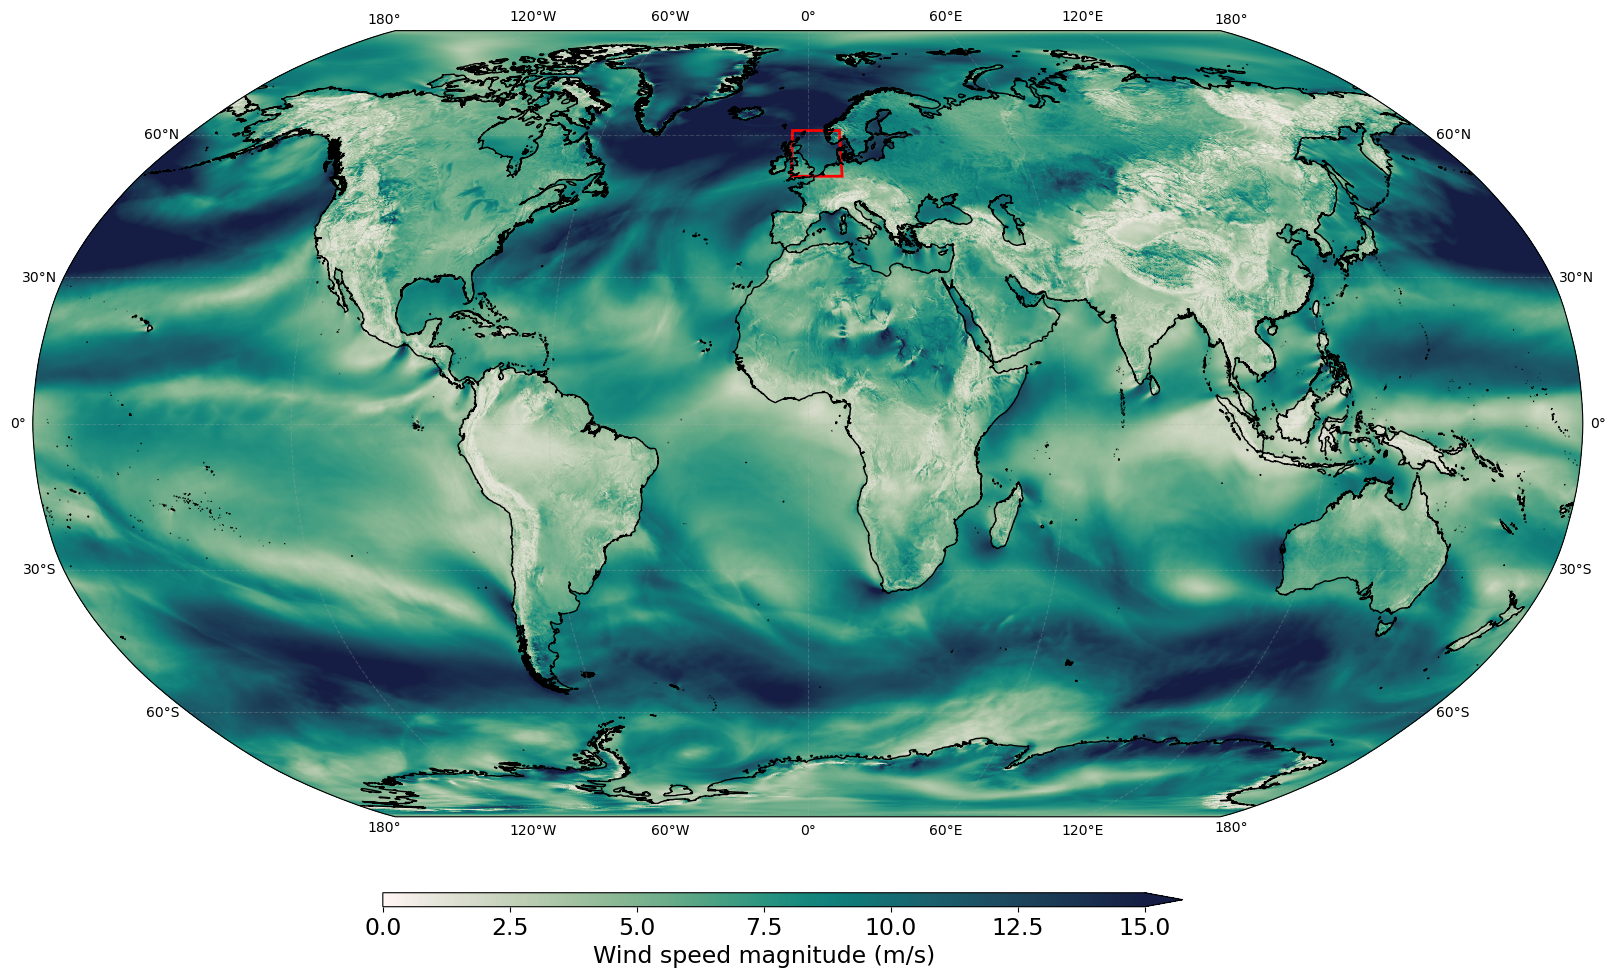

In [20]:
#Global map

path_output = '/home/bsc/bsc032984/projects/destination_earth/energy/energy_paper/figures/'

plot_map(ws_mean.values, ws_mean, 0, 15, cmo.tempo, 'Wind speed magnitude (m/s)', title='', delta=12, 
         region='', grid='pcolormesh', extend='max', zero_contour=False, path_output=None)

In [21]:
#Capacity factor 

def power_output(ws, iec_class, rated_power, cut_in_speed, rated_speed, cut_out_speed):
    """
    Compute the estimated power output of a wind turbine.

    Input
    -------
    ws: numpy.ndarray ; (time * lat * lon)
        Wind speed magnitude at hub height (flattened array).
    iec_class: str
        IEC wind turbine class. Options are 'I','I/II', 'II', 'II/III', 'III', 'S'.
    rated_power: int
        Rated power of the wind turbine in MW.
    cut_in_speed: float
        Cut-in speed of the wind turbine in m s^(-1).
    rated_speed: float
        Rated speed of the wind turbine in m s^(-1).
    cut_out_speed: float
        Cut-out speed of the wind turbine in m s^(-1).

    Output
    -------
    power_out: xarray.DataArray ; (time * lat * lon)
        Power output in kW (flattened array).

    References
    -------
    [1]: https://doi.org/10.1016/j.rser.2009.07.028 
    [2]: https://doi.org/10.3389/fenrg.2021.769920 
    [3]: https://www.thewindpower.net/turbine_es_5_enercon_e70-2300.php
    [4]: https://www.thewindpower.net/turbine_es_44_gamesa_g80-2000.php
    [5]: https://www.thewindpower.net/turbine_es_46_gamesa_g87-2000.php
    [6]: https://www.thewindpower.net/turbine_es_779_vestas_v100-2000.php
    [7]: https://www.thewindpower.net/turbine_es_590_vestas_v110-2000.php
    [8]: https://www.thewindpower.net/turbine_es_1476_vestas_v164-9500.php
    [9]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html 
    """
    from scipy.optimize import curve_fit

    #Check if the IEC class is valid.
    if iec_class not in ['I','I_II','II','II_III','III','S']:
        raise ValueError('The IEC class is not valid. Options are "I","I/II", "II", "II/III", "III", "S".')

    iec_to_t = {'I': 0,'I_II': 1,'II': 2,'II_III': 3,'III': 4,'S': 5}
    t = iec_to_t.get(iec_class, -1)

    turbines = ['Enercon_E70_2.3MW',
                'Gamesa_G80_2.0MW',
                'Gamesa_G87_2.0MW',
                'Vestas_V100_2.0MW',
                'Vestas_V110_2.0MW',
                'Vestas_V164_9.5MW']

    #Read the csv file with the manufacturer power curve.
    path = '/home/bsc/bsc032984/projects/destination_earth/energy/energy_paper/power_curves/'
    power_curve_data = pd.read_csv(path + f'{turbines[t]}.csv', skiprows=1, sep=',')

    #Define a parametrized Weibull Cumulative Distribution Function to fit the power curve.
    def weibull_distribution(x, alfa, k):
        f = rated_power - rated_power * np.exp(-(x * alfa)**k)
        return f 

    x_data = power_curve_data.wind_speed[:]
    y_data = power_curve_data.power[:]

    #Fit the manufacture power curve to the Weibull Cumulative Distribution Function.
    popt, _ = curve_fit(weibull_distribution, x_data, y_data, p0=(0.1, 1))

    #Extract the optimized parameters
    alfa_opt, k_opt = popt

   #Evaluate power output at given wind speeds using the piecewise definition.
    conditions = [(ws < cut_in_speed),
                  (ws >= cut_in_speed) & (ws <= rated_speed),
                  (ws > rated_speed) & (ws <= cut_out_speed),
                  (ws > cut_out_speed)]
    functions = [0,
                 lambda x: weibull_distribution(x, alfa_opt, k_opt),
                 rated_power,
                 0]

    #A piecewise function is used to obtain the power curve.
    power_out = np.piecewise(ws, conditions, functions)

    #Store the power curve and the wind values in an xarray.DataArray.
    attrs = {'shortname': 'po',
             'longname': 'Power output',
             'units': 'kW'}
    coords = {'wind_speed': ws}
    dims = ('wind_speed')

    power_out = xr.DataArray(power_out, coords=coords, dims=dims, attrs=attrs, name=attrs['shortname'])

    return power_out

def capacity_factor(ws, iec_class):
    """
    Compute the capacity factor of a wind turbine.

    Input
    -------
    ws: xarray.DataArray ; (time,lat,lon)
        Wind speed magnitude at hub height.
    iec_class: str
        IEC wind turbine class. Options are 'I','I/II', 'II', 'II/III', 'III', 'S'.

    Output
    -------
    cf: xarray.DataArray ; (time,lat,lon)
        Capacity factor.

    References
    -------
    [1]: https://doi.org/10.1016/j.renene.2019.04.135

    """
    #Check if the IEC class is valid.
    if iec_class not in ['I','I_II','II','II_III','III','S']:
        raise ValueError("Input argument 'iec_class' must be 'I','I/II','II','II/III', 'III' or 'S'.")

    #Class I
    class_I = {
        'turbine_model': 'Enercon E70',
        'rotor_diameter': 71,
        'rated_power': 2.3,
        'hub_height': 85,
        'cut_in_speed': 2.0,
        'rated_speed': 15.5,
        'cut_out_speed': 25.0
    }

    #Class I/II
    class_I_II = {'turbine_model': 'Gamesa G80',
                  'rotor_diameter': 80,
                  'rated_power': 2.0,
                  'hub_height': 80,
                  'cut_in_speed': 3.5,
                  'rated_speed': 15.0,
                  'cut_out_speed': 25.0}

    #Class II
    class_II = {'turbine_model': 'Gamesa G87',
                'rotor_diameter': 87,
                'rated_power': 2.0,
                'hub_height': 83.5,
                'cut_in_speed': 3.0,
                'rated_speed': 14.0,
                'cut_out_speed': 25.0}

    #Class II/III
    class_II_III = {'turbine_model': 'Vestas V100',
                    'rotor_diameter': 100,
                    'rated_power': 2.0,
                    'hub_height': 100,
                    'cut_in_speed': 3.5,
                    'rated_speed': 12.0,
                    'cut_out_speed': 20.0}

    #Class III
    class_III = {'turbine_model': 'Vestas V110',
                 'rotor_diameter': 110,
                 'rated_power': 2.0,
                 'hub_height': 100,
                 'cut_in_speed': 4.0,
                 'rated_speed': 12.0,
                 'cut_out_speed': 20.0}

    #Class S
    class_S = {'turbine_model': 'Vestas V164',
               'rotor_diameter': 164,
               'rated_power': 9.5,
               'hub_height': 105,
               'cut_in_speed': 3.5,
               'rated_speed': 14.0,
               'cut_out_speed': 25.0}

    turbine_class = [class_I, class_I_II, class_II, class_II_III, class_III, class_S]

    iec_to_t = {'I': 0,'I_II': 1,'II': 2,'II_III': 3,'III': 4,'S': 5}
    t = iec_to_t.get(iec_class, -1)

    #Compute the power curve of the wind turbine.
    rated_power = turbine_class[t]['rated_power'] * 10**3 #Convert to Watts.
    cut_in_speed = turbine_class[t]['cut_in_speed']
    rated_speed = turbine_class[t]['rated_speed']
    cut_out_speed = turbine_class[t]['cut_out_speed']

    #Flatten the wind array
    ws_flatten = np.array(ws).flatten()

    #Obtain the power output
    power_out_flatten = power_output(ws_flatten, iec_class, rated_power, cut_in_speed, rated_speed, cut_out_speed)

    #Reshape power output to match original wind speed input array.
    power_out = np.reshape(np.array(power_out_flatten), ws.shape)

    #Compute the capacity factor.
    cf = power_out / rated_power

    #Add metadata to the output variable.
    attrs = {'shortname': 'cf',
             'longname': 'Capacity factor',
             'units': '-'}
    coords = {'time': ws.time,
              'lat': ws.lat,
              'lon': ws.lon}
    dims = ('time', 'lat', 'lon')

    cf = xr.DataArray(cf, coords=coords, dims=dims, attrs=attrs, name=attrs['shortname'])

    return cf

In [22]:
cf = capacity_factor(ws, 'S')

In [23]:
cf_mean = cf.mean(dim='time')

In [75]:
def plot_map(data, ds, xmin, xmax, colormap, label, title, delta=12, region='eur', grid='pcolormesh', extend='neither', zero_contour=False, path_output=None):   
    import matplotlib.ticker as ticker
    from matplotlib.patches import Rectangle
    
    data_crs = ccrs.Robinson() #Type of projection.
    if region == 'eur':
        data_crs = ccrs.PlateCarree()
    if region == 'iber':
        data_crs = ccrs.PlateCarree()
    if region == 'nsea':
        data_crs = ccrs.PlateCarree()
    fig = plt.figure(constrained_layout=True, figsize=(20,14))
    #For multiplots
    fig.subplots_adjust(bottom=0.14, top=0.90, left=0.05, right=0.95)
    nrow = 1
    ncol = 1
    outer = gs.GridSpec(nrow, ncol, wspace=0.01, hspace=0.02)

    var = data
    lon = ds.lon.values
    lat = ds.lat.values

    fsize = 17 #Fontsize
    for i in range(nrow*ncol):
        ax = plt.subplot(outer[i], projection = data_crs)
        if region == 'eur':
            ax.set_extent([-25.0, 45.0, 27.0, 72.0], crs=data_crs)
        elif region == 'iber':
            ax.set_extent([-10.0, 5.0, 35.0, 45.0], crs=data_crs)
        elif region == 'nsea':
            ax.set_extent([-4.5, 9.25, 51.0, 61.0], crs=data_crs)
        else:
            pass
        
        ax.coastlines(resolution = '10m') #Draws the coastline.
        #ax.add_feature(cfeature.LAKES, edgecolor = 'black') #Adds lakes.
        ax.add_feature(cfeature.RIVERS, alpha=0.5) #Adds rivers.
        #ax.add_feature(cfeature.BORDERS) #Adds borders
        
        gl = ax.gridlines(draw_labels = False, linestyle='dashed', alpha=0.25) #Draws meridians and parallels.
        gl.xlabels_top = False
        gl.ylabels_right = False

        vmin,vmax = xmin,xmax
        delta = delta
        norm = mpc.PowerNorm(gamma=1, vmin=vmin, vmax=vmax)
        cmap = plt.cm.get_cmap(colormap)
        #cmap.set_bad('lightblue', alpha=1.)

        ax.add_feature(cfeature.OCEAN) #Adds oceans.
            
        lon2d,lat2d = np.meshgrid(lon,lat)
        if grid == 'pcolormesh':
            cs = ax.pcolormesh(lon2d, lat2d, var, norm=norm, transform=ccrs.PlateCarree(), cmap=cmap)
            if zero_contour == True:
                cl = ax.contour(lon2d, lat2d, var, [0], colors='black', linestyles='dashed', linewidths=1.0, transform=ccrs.PlateCarree(), alpha=0.7)
             
        elif grid == 'contourf':
            clevs = np.linspace(vmin,vmax,256)
            cs = ax.contourf(lon2d, lat2d, var, levels=clevs, norm=norm, transform=ccrs.PlateCarree(), cmap=cmap, extend=extend)
            if zero_contour == True:
                cl = ax.contour(lon2d, lat2d, var, [0], colors='black', linestyles='dashed', linewidths=1.0, transform=ccrs.PlateCarree(), alpha=0.7)

        # Add the rectangle to the plot
        #rect = Rectangle((-4.5, 51), 13.75, 10, linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
        #ax.add_patch(rect)

        # Make the colorbar fit the plot
        cbar_ax = fig.add_axes([ax.get_position().x0, ax.get_position().y0, 
                        ax.get_position().width, 0.02])
        cbar = fig.colorbar(cs, cax = cbar_ax, orientation='horizontal', extend=extend)
        cbar.set_label(label, rotation=0, fontsize=fsize)

        cbar.ax.tick_params(labelsize=fsize)
        #tick_locator = ticker.MaxNLocator(nbins=delta/2) # set the number of ticks
        #cbar.locator = tick_locator
        #cbar.update_ticks()

        #ax.set_title(title)

    if path_output is not None:
        plt.savefig(path_output, dpi=300, bbox_inches='tight')

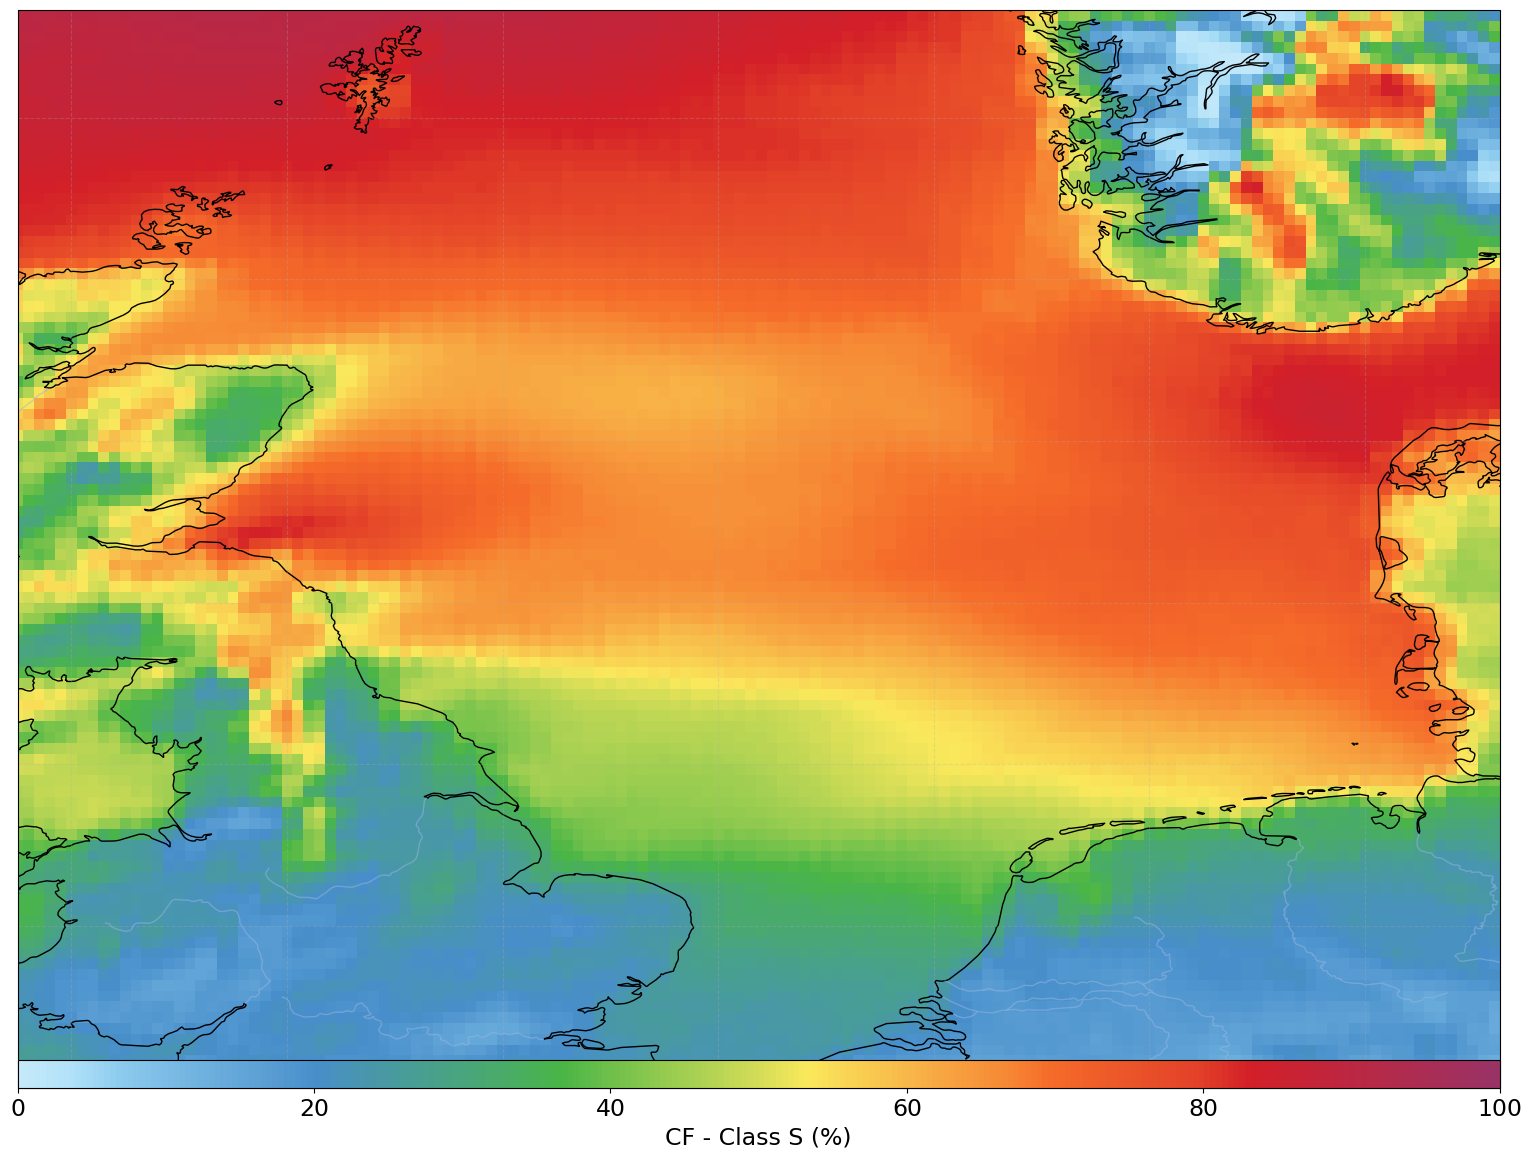

In [76]:
#Regional map

path_output = '/home/bsc/bsc032984/projects/destination_earth/energy/energy_paper/figures/'

plot_map(cf_mean.values*100, cf_mean, 0, 100, cmap_gwa, 'CF - Class S (%)', title='', delta=12, 
         region='nsea', grid='pcolormesh', extend='neither', zero_contour=False, path_output=path_output+'destine_nsea_cf_a1ym.png')

In [13]:
# Histogram

def plot_histogram(data, bins, color, edge_color, x_label, y_label, title, density=False):

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.hist(data, bins=bins, color=color, edgecolor=edge_color, density=density)

    # Setting the labels
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)

    # Ticks
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Limits
    ax.set_xlim(0, 1)

    # Legend
    ax.legend(fontsize=15)

    # Title
    ax.set_title(title, fontsize=16)

    # Grid
    ax.grid(True, alpha=0.8)

In [24]:
# Select Moray East wind farm

cf_me = cf.sel(lat=slice(58.1, 58.26), lon=slice(-2.82, -2.52))

In [25]:
cf_me_mean = cf_me.mean(dim='lat').mean(dim='lon')

In [26]:
cf_me_mean

<xarray.DataArray 'cf' (time: 168)> Size: 1kB
array([0.99684022, 0.98658972, 0.98838546, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.98674858, 0.96674542, 0.95250561,
       0.9604236 , 0.99289665, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99321491, 0.92033112, 0.48607525, 0.19677768,
       0.13101065, 0.07047336, 0.09088376, 0.02496237, 0.02446198,
       0.        , 0.        , 0.00241755, 0.02295121, 0.03526446,
       0.09746993, 0.11068502, 0.05702414, 0.03536682, 0.02863753,
       0.02805446, 0.01026399, 0.03309647, 0.04796193, 0.02681455,
       0.00992225, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01357604, 0.07322885,
       0.14235823, 0.28      , 0.31885908, 0.2895099 , 0.42911094,
       0.52306628, 0.61611239, 0.70595461, 0.75377883, 0.91735261,
       0.83433327, 0.80434868, 0.77608039, 0.836232  , 0.82925303,
       0.74530263, 0.78945202, 0.86350285, 0.87257036, 0.8944272 ,
       0.9294048 , 0.95644816, 0.96534092, 0.99694479, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97302803, 0.57368861, 0.39141962, 0.22111086,
       0.18718666, 0.29899299, 0.37815094, 0.32995449, 0.31698212,
       0.34086902, 0.3618394 , 0.22572824, 0.27855893, 0.38416577,
       0.39471217, 0.35794105, 0.29196241, 0.32210177, 0.43104149,
       0.34393209, 0.3899812 , 0.46994731, 0.29805915, 0.20266172,
       0.32943088, 0.28575467, 0.33716312, 0.27145332, 0.34800907,
       0.46990867, 0.51742844, 0.74844171, 0.93330741, 0.93665378,
       0.9326558 , 0.96630988, 0.94864987, 0.95412368, 0.97911854,
       0.99648096, 1.        , 1.        , 1.        , 1.        ,
       0.99731502, 0.99700315, 1.        , 0.99252726, 0.96379195,
       0.93761056, 0.9918052 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])
Coordinates:
  * time     (time) datetime64[ns] 1kB 1990-01-01 ... 1990-01-07T23:00:00

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


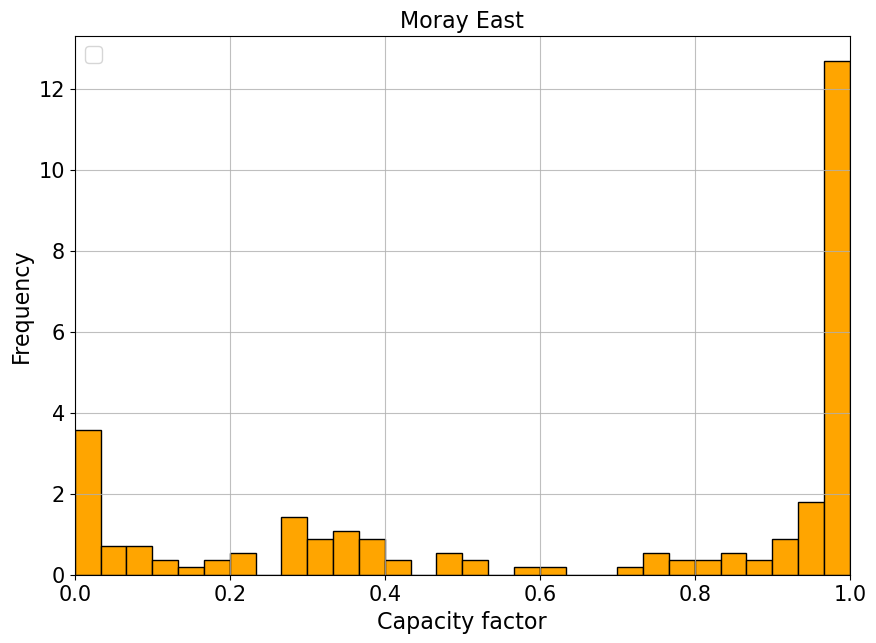

In [84]:
plot_histogram(cf_me_mean.values, bins=30, color='orange', edge_color='black', x_label='Capacity factor', y_label='Frequency', title='Moray East', density=True)

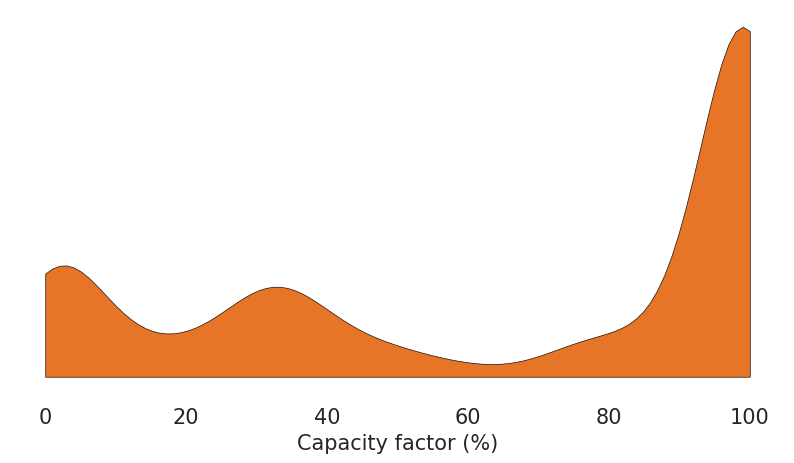

In [35]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import Normalize

# Example list of arrays, each array contains hourly wind speeds for a month
# Replace these with your actual data loading and KDE computation
weekly_wind_speeds = cf_me_mean.values * 100 # Example data

# Assuming you have the date range covered by your data
date_range = pd.date_range('1990-01-01', periods=len(weekly_wind_speeds), freq='W')
date_label = ''
#date_label = date_range.strftime('%Y-%b')[0]


# Set the aesthetic style of the plots with a light background
sns.set_theme(style="dark", rc={'axes.facecolor': (0, 0, 0, 0), 'figure.facecolor': 'none'})

# Create a continuous colormap
cmap = sns.color_palette("YlOrBr", as_cmap=True)
#cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

# Find the global minimum and maximum wind speed to normalize the colors
min_wind_speed = min(map(np.min, weekly_wind_speeds))
max_wind_speed = max(map(np.max, weekly_wind_speeds))

# Normalize object to map wind speeds to the colormap
norm = Normalize(vmin=min_wind_speed, vmax=max_wind_speed)

# Determine the x-axis range for all plots to avoid computing it in each iteration
p = np.linspace(0, 100, 100)  # Adjust as necessary for your wind speed range

# Compute KDE for each month and store the results
densities = gaussian_kde(weekly_wind_speeds, bw_method=0.15)(p)

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each KDE with a different color from the colormap based on wind intensity

mean_wind_speed = np.mean(weekly_wind_speeds)  # Calculate mean wind speed for the month
color = cmap(norm(mean_wind_speed))     # Get the corresponding color from the colormap
ax.fill_between(p, densities, color=color, alpha=0.9, edgecolor='black', lw=0.5)
ax.text(-0.125, 0.27, date_label, transform=ax.transAxes, fontweight="bold", va='top', color='black')  # Label color set to black
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom']
#ax.set_facecolor('#f5f5f5')  # Light grey background for each subplot

# Set the facecolor for the entire figure
#fig.patch.set_facecolor('#f5f5f5')

# Set xtick font size
plt.xticks(fontsize=15)

# Adjust space between plots and remove x-axis labels except for the last subplot
#plt.subplots_adjust(hspace=-0.7)  # Adjust this value as needed
ax.set_xlabel('Capacity factor (%)', fontsize=15)
#axes[-1].set_xticks([0,5,10,15,20,25],minor=True)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [20]:
# Histogram

def plot_histogram(data, bins, color, edge_color, x_label, y_label, title, density=False):

    fig, ax = plt.subplots(figsize=(10, 7))
    
    bin_edges = np.arange(0, 25, 0.5)
    ax.hist(data, bins=bin_edges, color=color, edgecolor=edge_color, density=density)

    # Setting the labels
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)

    # Ticks
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Limits
    ax.set_xlim(0, 25)

    # Vertical lines
    ax.axvline(3.5, color='green', linestyle='dashed', linewidth=2.5)
    ax.axvline(14.0, color='darkorange', linestyle='dashed', linewidth=2.5)

    # Legend
    ax.legend(fontsize=15)

    # Title
    ax.set_title(title, fontsize=16)

    # Grid
    ax.grid(True, alpha=0.8)

In [21]:
ws_me = ws.sel(lat=slice(58.1, 58.26), lon=slice(-2.82, -2.52))

In [22]:
ws_me_mean = ws_me.mean(dim='lat').mean(dim='lon')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


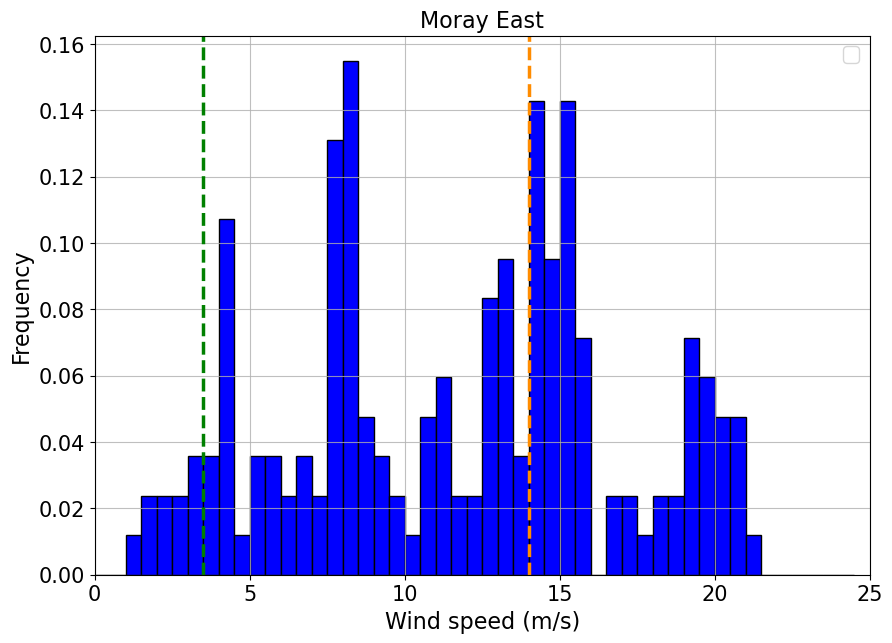

In [23]:
plot_histogram(ws_me_mean.values, bins=25, color='blue', edge_color='black', x_label='Wind speed (m/s)', y_label='Frequency', title='Moray East', density=True)

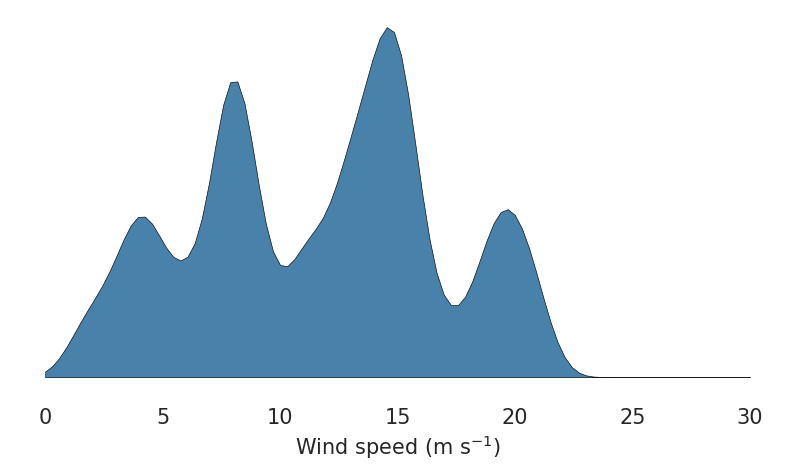

In [27]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import Normalize

# Example list of arrays, each array contains hourly wind speeds for a month
# Replace these with your actual data loading and KDE computation
weekly_wind_speeds = ws_me_mean.values # Example data

# Assuming you have the date range covered by your data
date_range = pd.date_range('1990-01-01', periods=len(weekly_wind_speeds), freq='W')
date_label = ''
#date_label = date_range.strftime('%Y-%b')[0]

# Set the aesthetic style of the plots with a light background
sns.set_theme(style="dark", rc={'axes.facecolor': (0, 0, 0, 0), 'figure.facecolor': 'none'})

# Create a continuous colormap
cmap = sns.color_palette("mako_r", as_cmap=True)
#cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

# Find the global minimum and maximum wind speed to normalize the colors
min_wind_speed = min(map(np.min, weekly_wind_speeds))
max_wind_speed = max(map(np.max, weekly_wind_speeds))

# Normalize object to map wind speeds to the colormap
norm = Normalize(vmin=min_wind_speed, vmax=max_wind_speed)

# Determine the x-axis range for all plots to avoid computing it in each iteration
p = np.linspace(0, 30, 100)  # Adjust as necessary for your wind speed range

# Compute KDE for each month and store the results
densities = gaussian_kde(weekly_wind_speeds, bw_method=0.15)(p)

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each KDE with a different color from the colormap based on wind intensity

mean_wind_speed = np.mean(weekly_wind_speeds)  # Calculate mean wind speed for the month
color = cmap(norm(mean_wind_speed))     # Get the corresponding color from the colormap
ax.fill_between(p, densities, color=color, alpha=0.9, edgecolor='black', lw=0.5)
ax.text(-0.075, 0.27, date_label, transform=ax.transAxes, fontweight="bold", va='top', color='black')  # Label color set to black
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom']
#ax.set_facecolor('#f5f5f5')  # Light grey background for each subplot

# Set the facecolor for the entire figure
#fig.patch.set_facecolor('#f5f5f5')

# Adjust space between plots and remove x-axis labels except for the last subplot
#plt.subplots_adjust(hspace=-0.7)  # Adjust this value as needed
ax.set_xlabel('Wind speed (m s$^{-1}$)', fontsize=15)
#axes[-1].set_xticks([0,5,10,15,20,25],minor=True)

# Set xtick font size
plt.xticks(fontsize=15)

# Add vertical lines
#ax.axvline(3.5, color='green', linestyle='dashed', linewidth=2.5)
#ax.axvline(14.0, color='darkorange', linestyle='dashed', linewidth=2.5)

plt.show()